# DEEP LEARNING MODEL ON MNIST DATASET

## The architecture of this model comprises of three hidden layer with 500, 250 and 100 being their respective sizes

---

### The aim is to model a complete handwritten digit recognizer, train it on the train set comprising 60,000 images and test performance on the test set comprising 10,000 images

---

## Baseline model includes: 
   - **Training data size of MNIST data = 60,000**
       * **with its respective batch size being 64**
   - **Testing data size of MNIST data = 10,000**
   - **Learning rate = 0.01**
   - **number of epochs = 15** 
   


## Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as data
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots

#Setting up GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Feature batch shape: torch.Size([60000, 28, 28])
Labels batch shape: torch.Size([60000])


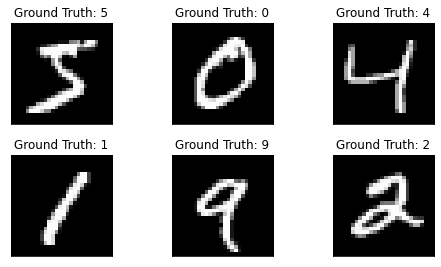

In [5]:
train_set = data.MNIST(root = 'MNIST/raw/train-images-idx3-ubyte', train = True, transform= ToTensor(), download = True)
test_set = data.MNIST(root= 'MNIST/raw/train-images-idx3-ubyte', train= False, transform= ToTensor(), download = True)

train_features = train_set.data
train_labels = train_set.targets
# Visualising data
# Display image and label

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_features[i].squeeze(), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(train_labels[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()


In [6]:
batchsize = 64
input_size = (train_features.reshape(train_features.shape[0],-1)).shape[1]
hidden_layer_1 = 500
hidden_layer_2 = 250
hidden_layer_3 = 100
output_layer = 10
learning_rate = 0.01

In [34]:
def one_hot_encode(Y):
  output = np.eye(10)[np.array(Y).reshape(-1)]
  return output.reshape(list(np.shape(Y))+[10])


def tanh(x):
    return ((np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x)))


def softmax(x):
    return np.exp(x)/sum(np.exp(x))
    
def derivative_tanh(x):
    t = activation(x, 'TANH')
    return (1-t**2)

def data_flattening(features, labels, one_hot = True):
    features = features.numpy()
    labels = labels.numpy()
    X = (features.reshape(features.shape[0], -1))
    if one_hot:
      Y = one_hot_encode(labels)
    else:
      Y = labels
    return X, Y

#Function to Initialise the parameters

def initialise_parameter(dim):
  np.random.seed(11)

  parameters = {}
  L = len(dim)
  for i in range(1, L):
    Ni = dim[i-1]
    No = dim[i]
    M = np.sqrt(6/(Ni+No)) 
    parameters["W" + str(i)] = np.asarray(np.random.uniform(-M, M,size = (No,Ni)))
    parameters["b" + str(i)] = np.zeros((dim[i], 1))
        
    assert(parameters["W" + str(i)].shape == (dim[i], dim[i-1]))
    assert(parameters["b" + str(i)].shape == (dim[i], 1))
  return parameters


def forward_propagation(X,parameters):
    W1=parameters["W1"]
    b1=parameters["b1"]
    W2=parameters["W2"]
    b2=parameters["b2"]
    W3=parameters["W3"]
    b3=parameters["b3"]
    W4=parameters["W4"]
    b4=parameters["b4"]
    Z1=np.dot(W1,X.T)+b1
    A1=tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2=tanh(Z2)
    Z3 = np.dot(W3,A2) + b3
    A3=tanh(Z3)
    Z4=np.dot(W4,A3)+b4
    A4=softmax(Z4)

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3 , Z4 ,A4 , W4 , b4)

    return A4,cache

# GRADED FUNCTION: backward_propagation_with_regularization

def backward_propagation(X, Y, cache, lambd):
   
    m = batchsize
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3 , Z4 ,A4 , W4 , b4) = cache
   
    dZ4 = A4 - Y
    dW4 = (1./m)*((np.dot(dZ4, A3.T)))+((lambd/m)*W4)
    db4 = 1./m * np.sum(dZ4, axis=1, keepdims = True)
    
    dA3 = np.dot(W4.T, dZ4)
    dZ3 = np.multiply(dA3, derivative_tanh(A3))
    dW3 = (1./m)*((np.dot(dZ3, A2.T)))+((lambd/m)*W3)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, derivative_tanh(A2))
    dW2 = (1./m)*((np.dot(dZ2, A1.T)))+((lambd/m)*W2)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, derivative_tanh(A1))
    dW1 = (1./m)*((np.dot(dZ1, X)))+((lambd/m)*W1)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ4": dZ4, "dW4": dW4, "db4": db4,
                "dA3": dA3, "dZ3": dZ3, "dW3": dW3, "db3": db3,
                "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

def compute_cost(A, Y,cache, lambd):    
    #A is predicted
    #Y is actual
    m = Y.shape[1] 
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3 , Z4 ,A4 , W4 , b4) = cache
    logprobs = np.multiply(-np.log(A),Y) + np.multiply(-np.log(1 - A), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    L2_regularization_cost = (lambd/(2*m))*(np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3))+np.sum(np.square(W4)))
    costTotal = cost + L2_regularization_cost
    return costTotal

#Function to update the parameters

def update_parameters(parameters, grads, learning_rate):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    W4 = parameters["W4"]
    b4 = parameters["b4"]
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    dW3 = grads["dW3"]
    db3 = grads["db3"]
    dW4 = grads["dW4"]
    db4 = grads["db4"]
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W3 = W3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3
    W4 = W4 - learning_rate * dW4
    b4 = b4 - learning_rate * db4
    
    parameters={"W1":W1, "b1":b1,
                "W2":W2, "b2":b2,
                "W3":W3, "b3":b3,
                "W4":W4, "b4":b4}
    return parameters

# Predict Labels

def Accuracy(dataset, parameters, size):
  
    features = dataset.data
    labels = dataset.targets
    X, Y = data_flattening(features, labels, one_hot = False)
    y = Y.T
    p = np.zeros(size, dtype = int)
    # Forward propagation
    a4, caches = forward_propagation(X, parameters)
    p = np.argmax(a4, axis = 0)
    a = np.mean((p == y))
    
    print("accuracy is =" + str(a))
    
    return y, p

def find_accuracy(y_actual,y_pred):
    accuracy = np.count_nonzero(np.argmax(y_pred,axis=0)==np.argmax(y_actual,axis=1))/y_actual.shape[0]
    return accuracy

def predict(X,Y,parameters):

    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    Y -- data set of examples
    parameters -- parameters of the trained model
    
    Returns:
    ypred -- predictions for the given dataset X
    """

    y_pred,cache=forward_propagation(X,parameters)
    return y_pred

In [35]:
def model(dataset, numEpochs, lambd):
    
    k=len(dataset)                               #length of the dataset
    numBatches=k/batchsize
    layers_dims = [input_size, hidden_layer_1, hidden_layer_2, hidden_layer_3, output_layer]# number of batches = 60000/64 = 937
    parameters=initialise_parameter(layers_dims)     # initializing the parameters
    costs=[]                                          #cost accumulation
    acc=[]                                            #accuracy 
    for epoch in range(numEpochs):
        for j in range(int(numBatches)):
            # Data loader
            loader = DataLoader(dataset=dataset,batch_size = batchsize ,shuffle=True)      
            dataiter = iter(loader)
            data = next(dataiter)
            features, labels = data
            
            X, Y = data_flattening(features, labels, True)
            y_pred,cache=forward_propagation(X,parameters)
            cost=compute_cost(y_pred,Y.T, cache, lambd)
            gradients=backward_propagation(X,Y.T,cache, lambd)
            parameters=update_parameters(parameters,gradients,learning_rate)
            if j%200 ==0:
                print (f'Epoch [{epoch+1}/{numEpochs}], Step [{j+1}/{int(numBatches)}], Loss: {cost.item():.4f}')
            acc.append(find_accuracy(Y,y_pred))
            costs.append(cost)
    return parameters, costs, acc

In [41]:
train_parameters, train_costs, train_acc = model(train_set,15, 0.7)

Epoch [1/15], Step [1/937], Loss: 9.2180
Epoch [1/15], Step [201/937], Loss: 6.9773
Epoch [1/15], Step [401/937], Loss: 6.6116
Epoch [1/15], Step [601/937], Loss: 6.2354
Epoch [1/15], Step [801/937], Loss: 5.8071
Epoch [2/15], Step [1/937], Loss: 5.9277
Epoch [2/15], Step [201/937], Loss: 5.3748
Epoch [2/15], Step [401/937], Loss: 5.1373
Epoch [2/15], Step [601/937], Loss: 5.0750
Epoch [2/15], Step [801/937], Loss: 4.8159
Epoch [3/15], Step [1/937], Loss: 4.6255
Epoch [3/15], Step [201/937], Loss: 4.6047
Epoch [3/15], Step [401/937], Loss: 4.5472
Epoch [3/15], Step [601/937], Loss: 4.4994
Epoch [3/15], Step [801/937], Loss: 4.1898
Epoch [4/15], Step [1/937], Loss: 3.9538
Epoch [4/15], Step [201/937], Loss: 3.8346
Epoch [4/15], Step [401/937], Loss: 4.0730
Epoch [4/15], Step [601/937], Loss: 3.4899
Epoch [4/15], Step [801/937], Loss: 3.6199
Epoch [5/15], Step [1/937], Loss: 3.4327
Epoch [5/15], Step [201/937], Loss: 3.2664
Epoch [5/15], Step [401/937], Loss: 3.1833
Epoch [5/15], Step [6

In [43]:
train_acc[-1]

0.953125

In [44]:
print ("On the TEST set:")
y_actual_test, y_pred_test = Accuracy(test_set, trained_parameters, 10000)

On the TEST set:
accuracy is =0.9095


Text(0.5, 1.0, 'Confusion Matrix of Sigmoid Test Data')

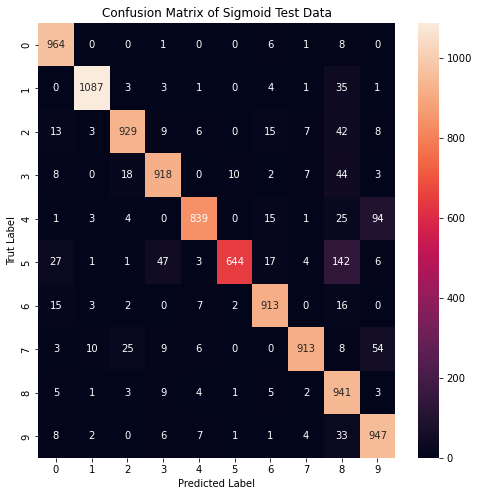

In [45]:
#to get the heatmap for the confusion matrix
import seaborn as sn
plt.figure(figsize=(8,8))
sn.heatmap(confusion_matrix(y_actual_test, y_pred_test),annot=True,fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('Trut Label')
plt.title('Confusion Matrix of Sigmoid Test Data')

In [46]:
c = confusion_matrix(y_actual_test, y_pred_test)
print(c)

[[ 964    0    0    1    0    0    6    1    8    0]
 [   0 1087    3    3    1    0    4    1   35    1]
 [  13    3  929    9    6    0   15    7   42    8]
 [   8    0   18  918    0   10    2    7   44    3]
 [   1    3    4    0  839    0   15    1   25   94]
 [  27    1    1   47    3  644   17    4  142    6]
 [  15    3    2    0    7    2  913    0   16    0]
 [   3   10   25    9    6    0    0  913    8   54]
 [   5    1    3    9    4    1    5    2  941    3]
 [   8    2    0    6    7    1    1    4   33  947]]


# Observations:

- Tanh showed good accuracy :
    * for trainset - 94.39%
    * for testset - 93.92%

- After applying regularization on the trainset with $\lambda$ = 0.7 and number of epochs = 15 we get accuracy as :
    * for trainset - 95.31%
    * for testset - 90.35%
    